<a href="https://colab.research.google.com/github/vence-andersen/M5-Forecasting-Accuracy/blob/main/Ensemble_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing modules required and reading the pickle file**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.metrics import make_scorer
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import pickle
import dill
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error as mse
from typing import Union
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_pickle('/content/drive/MyDrive/new.pkl')
data.head(2)

,id,item_id,dept_id,cat_id,store_id,state_id,day,demand,wm_yr_wk,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_28,lag_30,lag_35,lag_42,lag_49,lag_56,lag_63,lag_70,rolling_median_5,rolling_median_7,rolling_median_28,rolling_median_56
30490000,14370,1437,3,1,0,0,1001,2,11339,7,10,2013,-1,-1,-1,-1,0,0,0,8.257812,1.0,0.0,2.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
30490001,14380,1438,3,1,0,0,1001,0,11339,7,10,2013,-1,-1,-1,-1,0,0,0,3.970703,2.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


# **Train, Test Splits**

In [ ]:
# Now we are splitting our data into, Train, Test, Cross Validate.
# Being a time series model, we are splitting the data based on time.

# Records till day 1914 will be used for training the model.
X_train = data[data['day']<1800]

# Records after day 1942 will used for final test
X_test = data[(data['day']>=1800)]

y_train = X_train['demand']
y_test = X_test['demand']

# We are drpping the features which are not required.
X_train.drop(['demand'],axis = 1,inplace = True)
X_test.drop(['demand'],axis = 1,inplace = True)

print(X_train.shape,y_train.shape)
print(X_test.shape, y_test.shape)

(24361510, 27) (24361510,)
(5183300, 27) (5183300,)


In [ ]:
# We are then splitting the train data 50-50 as D1 and D2
X_train_D1 = X_train[X_train['day']<=1400]
X_train_D2 = X_train[X_train['day']>1400]

y_train_D1 = y_train[y_train.index <= X_train_D1.index[-1]].reset_index(drop=True)
y_train_D2 = y_train[y_train.index > X_train_D1.index[-1]].reset_index(drop=True)

X_train_D1.reset_index(drop=True, inplace=True)
X_train_D2.reset_index(drop=True, inplace=True)

In [ ]:
def sampler(max_val):
    """This function is used to create a sample dataset"""

    # siz variable defines that we are picking 70 percent of data with replacement
    siz = np.int(max_val * 0.70)
    return np.round(np.random.uniform(0,max_val-1, size=siz)).astype(int).tolist()

In [ ]:
# We are creating a sample dataset from X_train_D1 with 70 percent of data with replacement
k1_train = X_train_D1.iloc[sampler(X_train_D1.shape[0])].sort_index()
k1_test = y_train_D1[k1_train.index.tolist()]

k2_train = X_train_D1.iloc[sampler(X_train_D1.shape[0])].sort_index()
k2_test = y_train_D1[k2_train.index.tolist()]

k3_train = X_train_D1.iloc[sampler(X_train_D1.shape[0])].sort_index()
k3_test = y_train_D1[k3_train.index.tolist()]

k4_train = X_train_D1.iloc[sampler(X_train_D1.shape[0])].sort_index()
k4_test = y_train_D1[k4_train.index.tolist()]

k5_train = X_train_D1.iloc[sampler(X_train_D1.shape[0])].sort_index()
k5_test = y_train_D1[k5_train.index.tolist()]

# **Base Model_1 LassoRegression**

In [ ]:
params = {'alpha' : [0.001,0.01,0.1,1,10,0.05,0.5]}

lasso = Lasso()
clf = GridSearchCV(estimator=lasso, param_grid=params,scoring='neg_mean_squared_error', cv=3,n_jobs=-1, return_train_score=True, verbose=2)
clf.fit(k1_train, k1_test)

Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:  6.7min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10, 0.05, 0.5]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_squared_error', verbose=2)

In [ ]:
pd.DataFrame(clf.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,235.910277,115.114222,0.449364,0.110772,0.001,{'alpha': 0.001},-9.300288,-6.728264,-5.593564,-7.207372,1.550722,6,-6.091510,-6.731293,-7.282431,-6.701745,0.486640
1,45.621883,12.618110,0.525556,0.009781,0.01,{'alpha': 0.01},-8.061216,-6.731735,-5.593185,-6.795379,1.008574,1,-6.093672,-6.732590,-7.284107,-6.703456,0.486429
2,23.853307,6.788747,0.524748,0.007994,0.1,{'alpha': 0.1},-8.042578,-6.746187,-5.606258,-6.798341,0.995307,3,-6.098085,-6.738449,-7.290629,-6.709054,0.487297
3,17.539312,0.779091,0.469219,0.054044,1,{'alpha': 1},-7.892976,-6.954936,-5.777192,-6.875035,0.865611,5,-6.199850,-6.832927,-7.392355,-6.808377,0.487148
4,5.073261,0.033020,0.513901,0.006904,10,{'alpha': 10},-14.649081,-14.232338,-13.567071,-14.149497,0.445596,7,-13.898914,-14.107087,-14.439518,-14.148506,0.222636
5,28.724928,9.965209,0.517216,0.003129,0.05,{'alpha': 0.05},-8.054846,-6.738380,-5.600919,-6.798048,1.002700,2,-6.096868,-6.735576,-7.289137,-6.707194,0.487155
6,17.718964,4.316160,0.384079,0.080141,0.5,{'alpha': 0.5},-7.953620,-6.826102,-5.665469,-6.815064,0.934167,4,-6.123702,-6.764859,-7.319644,-6.736068,0.488666


In [ ]:
# We are here picking the worst performing model as our final meta_model will be a boosting type
model_1 = Lasso(alpha=10)
model_1.fit(k1_train, k1_test)

Lasso(alpha=10, copy_X=True, fit_intercept=True, max_iter=1000, normalize=False,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False)

# **Base Model_2 ElasticNet**

In [ ]:
params = {'alpha' : [0.001,0.01,0.1,1,10,0.05,0.5],
          'l1_ratio' : [0.01,0.1,1]}

elastic_net = ElasticNet(max_iter=250)
clf = GridSearchCV(estimator=elastic_net, param_grid=params, scoring='neg_mean_squared_error', cv=3, n_jobs=-1, return_train_score=True)
clf.fit(k2_train, k2_test)

GridSearchCV(cv=3, error_score=nan,
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=250, normalize=False,
                                  positive=False, precompute=False,
                                  random_state=None, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10, 0.05, 0.5],
                         'l1_ratio': [0.01, 0.1, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_squared_error', verbose=0)

In [ ]:
pd.DataFrame(clf.cv_results_)[['param_alpha','param_l1_ratio','mean_test_score','std_test_score','mean_train_score','std_train_score']]

,param_alpha,param_l1_ratio,mean_test_score,std_test_score,mean_train_score,std_train_score
0,0.001,0.01,-7.008939,1.134876,-6.759825,0.445865
1,0.001,0.1,-7.005909,1.130846,-6.759842,0.445875
2,0.001,1,-6.970998,1.084996,-6.759922,0.445868
3,0.01,0.01,-6.984481,1.102746,-6.759879,0.445881
4,0.01,0.1,-6.956313,1.065944,-6.759961,0.445856
5,0.01,1,-6.846965,0.923624,-6.761565,0.445658
6,0.1,0.01,-6.891132,0.981579,-6.760438,0.445884
7,0.1,0.1,-6.846741,0.922911,-6.762024,0.445838
8,0.1,1,-6.849989,0.911426,-6.766891,0.446364
9,1,0.01,-6.847806,0.915853,-6.765857,0.446318


In [ ]:
model_2 = ElasticNet(alpha=10,l1_ratio=1,max_iter=250)
model_2.fit(k2_train, k2_test)

ElasticNet(alpha=10, copy_X=True, fit_intercept=True, l1_ratio=1, max_iter=250,
           normalize=False, positive=False, precompute=False, random_state=None,
           selection='cyclic', tol=0.0001, warm_start=False)

# **Base Model_3 LinearRegression**

In [ ]:
model_3 = LinearRegression(n_jobs=-1)
model_3.fit(k3_train, k3_test)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

# **Base Model_4 CatBoostRegressor**

In [ ]:
a = pd.DataFrame()
for i in range(7):    
    params = {'learning_rate' : np.round(np.random.rand(1)/10,3).tolist(),
            'min_data_in_leaf' : np.random.randint(30,113, size=1).tolist()}

    cat_boost = CatBoostRegressor(logging_level="Silent", iterations=130)
    clf = GridSearchCV(estimator=cat_boost, param_grid=params, scoring='neg_mean_squared_error', cv=3, n_jobs=-1, return_train_score=True)
    clf.fit(k4_train, k4_test)
    b = pd.DataFrame(clf.cv_results_)
    a = pd.concat([a,b])

In [ ]:
a['diff'] = a['mean_test_score'] - a['mean_train_score']
a

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_min_data_in_leaf,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score,diff
0,204.562277,4.050206,8.234098,1.681667,0.08,64,"{'learning_rate': 0.08, 'min_data_in_leaf': 64}",-7.655887,-6.357202,-5.657410,-6.556833,0.827996,1,-5.333362,-5.757166,-6.031544,-5.707357,0.287200,-0.849476
0,195.732081,2.392888,7.542417,0.209229,0.01,58,"{'learning_rate': 0.01, 'min_data_in_leaf': 58}",-8.498353,-7.615193,-6.611726,-7.575091,0.770734,1,-6.860466,-7.419506,-7.804727,-7.361566,0.387664,-0.213525
0,203.481364,3.411693,7.841384,1.339718,0.062,85,"{'learning_rate': 0.062, 'min_data_in_leaf': 85}",-7.625060,-6.370864,-5.687565,-6.561163,0.802343,1,-5.412312,-5.855130,-6.141463,-5.802968,0.299951,-0.758194
0,201.468571,7.448985,8.829461,2.508677,0.076,45,"{'learning_rate': 0.076, 'min_data_in_leaf': 45}",-7.616364,-6.363570,-5.670653,-6.550196,0.805220,1,-5.345266,-5.768852,-6.052817,-5.722312,0.290725,-0.827884
0,206.265570,6.867411,8.409604,2.059425,0.085,84,"{'learning_rate': 0.085, 'min_data_in_leaf': 84}",-7.613725,-6.354042,-5.639351,-6.535706,0.816207,1,-5.325782,-5.740524,-6.003460,-5.689922,0.278965,-0.845784
0,200.146811,4.288425,8.262067,0.788359,0.041,43,"{'learning_rate': 0.041, 'min_data_in_leaf': 43}",-7.667145,-6.418632,-5.650671,-6.578816,0.830978,1,-5.519991,-6.027504,-6.313399,-5.953631,0.328092,-0.625185
0,197.601803,2.459887,7.341037,0.643270,0.03,96,"{'learning_rate': 0.03, 'min_data_in_leaf': 96}",-7.691362,-6.477534,-5.687901,-6.618932,0.823998,1,-5.637971,-6.175413,-6.472258,-6.095214,0.345285,-0.523718


In [ ]:
model_4 = CatBoostRegressor(learning_rate =  0.01, min_data_in_leaf =  58, logging_level="Silent", iterations=130)
model_4.fit(k4_train, k4_test)

# **Base Model_5 LightGBM**

In [ ]:
a = pd.DataFrame()
for i in range(7):    
    params = {'learning_rate' : np.round(np.random.rand(1)/10,3).tolist(),
              'min_data_in_leaf' : np.random.randint(30,113, size=1).tolist(),
              'num_leaves' : np.random.randint(30,120, size=1).tolist()}

    lgbm = LGBMRegressor()
    clf = GridSearchCV(estimator=lgbm, param_grid=params, scoring='neg_mean_squared_error', cv=3, n_jobs=-1, return_train_score=True)
    clf.fit(k5_train, k5_test)
    b = pd.DataFrame(clf.cv_results_)
    a = pd.concat([a,b])

In [ ]:
a['diff'] = a['mean_test_score'] - a['mean_train_score']
a

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_min_data_in_leaf,param_num_leaves,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score,diff
0,146.360600,3.862081,19.917107,2.175597,0.089,92,79,"{'learning_rate': 0.089, 'min_data_in_leaf': 9...",-7.434892,-6.621093,-6.229270,-6.761752,0.502142,1,-4.892678,-5.186086,-5.336751,-5.138505,0.184388,-1.623247
0,125.157988,2.091329,15.555063,0.771899,0.074,77,49,"{'learning_rate': 0.074, 'min_data_in_leaf': 7...",-7.436129,-6.556936,-6.082465,-6.691843,0.560804,1,-5.127670,-5.454839,-5.604500,-5.395670,0.199110,-1.296173
0,138.036163,2.092514,17.294474,1.237736,0.022,100,46,"{'learning_rate': 0.022, 'min_data_in_leaf': 1...",-7.507970,-6.812343,-6.057160,-6.792491,0.592457,1,-5.835271,-6.259846,-6.469700,-6.188272,0.263903,-0.604219
0,152.460183,3.376623,18.949485,1.357921,0.034,100,78,"{'learning_rate': 0.034, 'min_data_in_leaf': 1...",-7.405523,-6.560276,-6.034026,-6.666608,0.564937,1,-5.389676,-5.774196,-5.955057,-5.706310,0.235754,-0.960298
0,143.962533,3.311683,16.168720,0.745065,0.005,80,42,"{'learning_rate': 0.005, 'min_data_in_leaf': 8...",-10.182938,-9.939481,-9.036646,-9.719688,0.493104,1,-9.172816,-9.473449,-9.800658,-9.482308,0.256392,-0.237381
0,163.437983,1.338426,19.422637,0.258524,0.013,68,71,"{'learning_rate': 0.013, 'min_data_in_leaf': 6...",-7.962132,-7.481812,-6.635393,-7.359779,0.548470,1,-6.471019,-6.851560,-7.081490,-6.801356,0.251739,-0.558422
0,114.960509,2.287053,13.443021,1.001593,0.055,41,31,"{'learning_rate': 0.055, 'min_data_in_leaf': 4...",-7.386535,-6.557217,-5.964029,-6.635927,0.583396,1,-5.339150,-5.667614,-5.854938,-5.620567,0.213181,-1.015360


In [ ]:
model_5 = LGBMRegressor(learning_rate =  0.005, min_data_in_leaf =  80, num_leaves = 42)
model_5.fit(k5_train, k5_test)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.005, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
              min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=42,
              objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

# **Saving the session to prevent from re-running.**

In [ ]:
filename = 'copy_globalsave_1.pkl'
dill.dump_session(filename)

In [ ]:
!cp copy_globalsave.pkl /content/drive/MyDrive

In [ ]:
dill.load_session('/content/drive/MyDrive/copy_globalsave.pkl')

# **Predicting the values on the 5 base models and creating a Dataset**

In [ ]:
k1_pred = pd.Series(model_1.predict(X_train_D2))
k2_pred = pd.Series(model_2.predict(X_train_D2))
k3_pred = pd.Series(model_3.predict(X_train_D2))
k4_pred = pd.Series(model_4.predict(X_train_D2))
k5_pred = pd.Series(model_5.predict(X_train_D2))

In [ ]:
X_train_D2_pred = pd.concat([pd.DataFrame(k1_pred, columns=['k1_pred']), pd.DataFrame(k2_pred,columns=['k2_pred']),\
           pd.DataFrame(k3_pred,columns=['k3_pred']),pd.DataFrame(k4_pred,columns=['k4_pred']),\
           pd.DataFrame(k5_pred,columns=['k5_pred'])],axis=1)

X_train_D2_pred.head(2)

,k1_pred,k2_pred,k3_pred,k4_pred,k5_pred
0,1.213988,1.212713,0.802246,0.677279,0.951471
1,1.213584,1.212308,0.232422,0.662477,0.824897


In [ ]:
test_pred_1 = pd.Series(model_1.predict(X_test))
test_pred_2 = pd.Series(model_2.predict(X_test))
test_pred_3 = pd.Series(model_3.predict(X_test))
test_pred_4 = pd.Series(model_4.predict(X_test))
test_pred_5 = pd.Series(model_5.predict(X_test))

In [ ]:
predictions = pd.concat([pd.DataFrame(test_pred_1, columns=['test_pred_1']), pd.DataFrame(test_pred_2,columns=['test_pred_2']),\
           pd.DataFrame(test_pred_3,columns=['test_pred_3']),pd.DataFrame(test_pred_4,columns=['test_pred_4']),\
           pd.DataFrame(test_pred_5,columns=['test_pred_5'])],axis=1)

predictions.head(2)

,test_pred_1,test_pred_2,test_pred_3,test_pred_4,test_pred_5
0,1.213988,1.212713,0.613037,0.662477,0.884894
1,1.213584,1.212308,1.284668,0.908849,1.077123


# **Creating a meta model using predcited values of X_train_D2 and it's true values**

In [ ]:
for i in range(15):
    
    lr = np.round(np.random.rand()/10,3)
    num_leaves = np.random.randint(30,150)
    min_data_in_leaf = np.random.randint(50,150)
    
    lgb = LGBMRegressor(learning_rate=lr ,num_leaves=num_leaves ,min_data_in_leaf=min_data_in_leaf)
    lgb.fit(X_train_D2_pred, y_train_D2)
    
    # Calculating the mse for train values to check if the model is overfitting or underfitting
    train_pred = lgb.predict(X_train_D2_pred)

    train_m_s_e = mse(y_train_D2,train_pred)
    
    # After training the model, we are trying to predict the model on X_val to check it's accuracy
    y_pred = lgb.predict(predictions)
    
    # Now that it has predicted the values for X_val, we are calculating it's rmse
    m_s_e = mse(y_test,y_pred)

    print(f"For learning rate {lr}, num_leaves {num_leaves} and min_data_in_leaf {min_data_in_leaf}, the train MSE is {train_m_s_e} and valid MSE is {m_s_e} diff is {m_s_e - train_m_s_e}")
    print('*'*80)

For learning rate 0.099, num_leaves 100 and min_data_in_leaf 138, the train MSE is 5.901566823311719 and valid MSE is 6.314696340867779 diff is 0.41312951755605987
********************************************************************************
For learning rate 0.018, num_leaves 76 and min_data_in_leaf 75, the train MSE is 6.165910007452854 and valid MSE is 6.197485271639661 diff is 0.03157526418680767
********************************************************************************
For learning rate 0.071, num_leaves 135 and min_data_in_leaf 114, the train MSE is 5.900120806853764 and valid MSE is 6.313768139993319 diff is 0.41364733313955515
********************************************************************************
For learning rate 0.049, num_leaves 133 and min_data_in_leaf 101, the train MSE is 5.917993503037619 and valid MSE is 6.301181571326875 diff is 0.38318806828925656
********************************************************************************
For learning rate 0.05

In [ ]:
meta_model = LGBMRegressor(learning_rate=0.007,num_leaves=101 ,min_data_in_leaf=118)
meta_model.fit(X_train_D2_pred, y_train_D2)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.007, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001,
              min_data_in_leaf=118, min_split_gain=0.0, n_estimators=100,
              n_jobs=-1, num_leaves=101, objective=None, random_state=None,
              reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

In [ ]:
# Now splitting the values for the submission
val = X_test[(X_test['day']>1913) & (X_test['day']<1942)]
tst = X_test[X_test['day']>1941]

In [ ]:
final_1_val = model_1.predict(val)
final_1_tst = model_1.predict(tst)

final_2_val = model_2.predict(val)
final_2_tst = model_2.predict(tst)

final_3_val = model_3.predict(val)
final_3_tst = model_3.predict(tst)

final_4_val = model_4.predict(val)
final_4_tst = model_4.predict(tst)

final_5_val = model_5.predict(val)
final_5_tst = model_5.predict(tst)

In [ ]:
final_val_preds = pd.concat([pd.DataFrame(final_1_val, columns=['final_1_val']), pd.DataFrame(final_2_val,columns=['final_2_val']),\
           pd.DataFrame(final_3_val,columns=['final_3_val']),pd.DataFrame(final_4_val,columns=['final_4_val']),\
           pd.DataFrame(final_5_val,columns=['final_5_val'])],axis=1)

final_val_preds.head(2)

,final_1_val,final_2_val,final_3_val,final_4_val,final_5_val
0,1.213988,1.212713,0.887939,0.823942,1.056554
1,1.213584,1.212308,0.649902,0.667475,0.937174


In [ ]:
final_tst_preds = pd.concat([pd.DataFrame(final_1_tst, columns=['final_1_tst']), pd.DataFrame(final_2_tst,columns=['final_2_tst']),\
           pd.DataFrame(final_3_tst,columns=['final_3_tst']),pd.DataFrame(final_4_tst,columns=['final_4_tst']),\
           pd.DataFrame(final_5_tst,columns=['final_5_tst'])],axis=1)

final_tst_preds.head(2)

,final_1_tst,final_2_tst,final_3_tst,final_4_tst,final_5_tst
0,1.213988,1.212713,0.595947,0.667475,0.914447
1,1.213584,1.212308,0.357910,0.662477,0.824897


In [ ]:
pred_val_array = meta_model.predict(final_val_preds)
pred_test_array = meta_model.predict(final_tst_preds)

pred_val_array = np.reshape(pred_val_array, (-1, 28),order = 'F')
pred_test_array = np.reshape(pred_test_array, (-1, 28),order = 'F')

In [ ]:
sub = pd.read_csv("sample_submission.csv")
sub_1 = sub.iloc[:30490,:]
sub_2 = sub.iloc[30490:,:]
f_cols = sub.columns[1:]

for i in range(len(f_cols)):
    sub_1[f_cols[i]] = pred_val_array[:,i]
    sub_2[f_cols[i]] = pred_test_array[:,i]

sub = pd.concat([sub_1,sub_2])
sub

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,1.008821,0.969648,0.943631,0.780210,1.058942,0.945947,1.071161,0.995634,1.330632,1.096884,1.349534,1.203920,1.241572,1.203920,0.862546,1.251115,0.992293,1.096884,1.100746,1.193208,1.156122,1.038512,1.058942,1.065147,1.241572,1.038512,1.241572,1.038512
1,HOBBIES_1_002_CA_1_validation,0.895495,0.793189,0.753662,0.848594,0.742245,0.778792,0.808171,0.862546,0.756158,0.731740,0.895495,0.769317,0.843288,0.779491,0.812034,0.718000,0.751470,0.848594,0.756951,0.810674,0.832726,0.778792,0.716541,0.772309,0.760631,0.772309,0.773150,0.754468
2,HOBBIES_1_003_CA_1_validation,0.801090,0.791574,0.743095,0.710382,0.801090,1.038512,0.952546,0.773150,0.918212,0.737798,0.817468,0.808171,1.119456,0.880778,0.767155,0.772770,0.843288,0.982287,1.038512,1.297372,1.184010,0.918212,1.007070,0.918212,0.915374,1.016001,0.969648,1.065147
3,HOBBIES_1_004_CA_1_validation,1.744673,1.174411,0.929735,1.289802,1.230354,1.497883,2.177328,1.415720,1.275015,1.096884,1.376129,1.434238,1.759173,2.204446,1.701488,1.216656,1.358930,1.120969,1.415720,1.501199,2.177328,1.625229,1.297372,1.304719,1.156122,1.349299,2.168582,1.981936
4,HOBBIES_1_005_CA_1_validation,1.203920,1.127111,1.330632,1.157865,1.221156,1.203920,1.368777,1.184010,1.368777,1.120969,1.241572,1.054968,1.156122,1.233586,1.329496,1.120969,1.275015,1.060817,1.193208,1.184010,1.329496,1.184010,1.120969,1.130954,1.203920,1.272537,1.275015,1.563668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60975,FOODS_3_823_WI_3_evaluation,0.817819,0.769317,0.718000,0.943631,0.961660,0.858096,0.902876,0.789243,0.895495,0.758300,1.005922,1.058942,0.880778,0.992293,0.943631,0.895495,0.843288,0.895495,1.119456,0.858129,1.219005,0.812496,1.119456,0.906384,0.915374,1.016001,0.895495,1.071161
60976,FOODS_3_824_WI_3_evaluation,0.918212,0.859890,0.780210,0.859890,0.764844,0.943631,0.781909,0.813411,0.902876,0.816276,1.016001,0.758300,1.016001,0.895495,0.902876,0.880778,0.779491,0.918212,0.737798,0.918212,0.880778,0.895495,0.895495,0.775667,0.943631,0.726745,1.003606,0.757754
60977,FOODS_3_825_WI_3_evaluation,1.257981,0.895495,1.060817,0.816276,0.982287,1.193208,0.969648,1.349299,0.780210,1.119456,0.877577,0.929068,1.147010,1.142785,1.203920,1.071161,1.241572,1.120969,0.994609,1.120969,1.096884,1.275015,1.016621,1.388151,0.858800,0.927419,0.993318,1.184010
60978,FOODS_3_826_WI_3_evaluation,1.119456,1.434238,1.003606,1.233586,1.184010,1.119456,1.368777,1.184010,1.120969,1.156122,1.241572,1.156122,1.297372,1.358930,1.329496,1.096884,1.130954,1.193208,1.184010,1.184010,1.275015,1.415720,1.668891,1.257981,1.518178,1.130954,1.184010,1.147010


In [ ]:
sub.to_csv("stack_model_8.csv",index = False)

In [ ]:
!kaggle competitions submit -c m5-forecasting-accuracy -f stack_model_8.csv -m "Eigth stacked model"

100% 32.4M/32.4M [00:00<00:00, 60.0MB/s]
Successfully submitted to M5 Forecasting - Accuracy

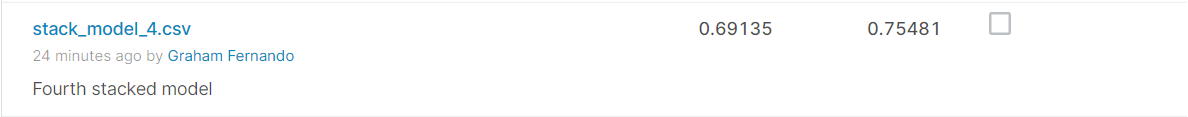